In [709]:
import os
import re
import pandas as pd

## Příprava dat

In [711]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [712]:
df = pd.read_parquet(os.path.join("data","cnb_ceska_proza.parquet"))
len(df)

47636

In [713]:
df = df.merge(pd.read_parquet(os.path.join("data","cnb_vyber.parquet")), left_index=True, right_index=True, how='inner')

In [714]:
len(df)

43978

In [715]:
df = df[df['rok'] >= 2019]

In [716]:
graf_rok_min = int(df['rok'].min())
graf_rok_min

2019

In [717]:
graf_rok_max = int(df['rok'].max())
graf_rok_max

2024

In [718]:
len(df)

8098

In [719]:
df = df.explode('020_a')

In [720]:
def isbn(x):
    try:
        if len(x.replace('-','')) == 13:
            return str(x.replace('-',''))
    except:
        pass

In [721]:
df['isbn'] = df['020_a'].apply(lambda x: isbn(x))

In [722]:
df[['020_a','isbn']].sample(20)

,020_a,isbn
001,,
nkc20203275154,978-80-7376-568-2,9788073765682
nkc20213329604,978-80-7565-863-0,9788075658630
nkc20233500490,978-80-7633-863-0,9788076338630
nkc20213314863,978-80-87210-79-6,9788087210796
nkc20243595748,978-80-7588-572-2,9788075885722
nkc20213303291,978-80-7443-391-7,9788074433917
nkc20203265040,978-80-7546-316-6,9788075463166
nkc20233521190,978-80-88635-06-2,9788088635062
nkc20243581855,978-80-908001-2-0,9788090800120


In [723]:
odkud = "data_raw/ebooky"

In [724]:
stazene = set([x.split(".")[0] for x in os.listdir(odkud)])
len(stazene)

2732

In [725]:
df = df[df['isbn'].isin(stazene)]

In [726]:
df

,rok,titul,autorstvo,autorstvo_kod,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,isbn
001,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nkc20193162055,2019.0,Ke Gogolovi a zpátky,Rollingerová-Riba Romana,jo20000075610,191127s2019 xr g 000 f cze,978-80-7487-279-2,"[Kč 299,00]",[(brožováno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-31)]",[aut],jo20000075610,"Rollingerová-Riba, Romana,",1971-,None,Ke Gogolovi a zpátky /,Romana Riba-Rollingerová,None,None,None,[Vydání první],None,None,None,None,None,None,None,[V Brumovicích :],"[Carpe diem,]",[2019],[1],[267 stran ;],None,[19 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, Czech fiction]",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,9788074872792
nkc20193161777,2019.0,Dobře zašitej frajer,Šabach Petr,jn19990201046,191211s2019 xr g 000 j cze,978-80-7637-070-8,"[Kč 399,00]",[(vázáno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, (0:82-32), (082.21)]",[aut],jn19990201046,"Šabach, Petr,",1951-2017,None,Dobře zašitej frajer /,to nejlepší z Petra Šabacha uspořádali Emil Ha...,None,None,None,[Vydání první],None,None,None,None,None,None,None,[V Praze :],"[Paseka,]",[2019],[1],[333 stran ;],None,[23 cm],None,None,"[Údaj o vydání je chybný, správně má být: Vydá...",None,None,None,None,None,None,None,None,None,"[české povídky, české novely, výbory, Czech sh...","[edt, edt]","[jn20000400849, jn19990209335]","[Hakl, Emil,, Kahuda, Václav,]","[1958-, 1965-2023]",None,None,None,None,None,None,None,nam a22 i 4500,9788076370708
nkc20193162052,2019.0,Čarodějnice,Vostrý Mirek,mzk2018995176,200120s2019 xr g 000 j cze,978-80-88318-05-7,None,[(brožováno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, (0:82-32)]",[aut],mzk2018995176,"Vostrý, Mirek,",1968-,None,Čarodějnice /,Mirek Vostrý,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brandýs n/L :],"[Tofana,]",[2019],[1],[187 stran ;],None,[19 cm],None,None,[150 výtisků],None,None,None,None,None,None,None,None,None,"[české povídky, Czech short stories]",None,None,None,None,None,None,None,None,None,None,None,nam a22 i 4500,9788088318057
nkc20193158828,2019.0,Mstitel z Jenštejna,Vondruška Vlastimil,xx0004129,191111s2019 xr g 000 f cze,978-80-243-8905-9,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-311.6), (0:82-312.4)]",[aut],xx0004129,"Vondruška, Vlastimil,",1955-,None,Mstitel z Jenštejna /,Vlastimil Vondruška,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brno :],"[MOBA,]",[2019],[1],[219 stran ;],None,[21 cm],[Letopisy královské komory ;],[XIII],None,None,None,None,None,None,None,None,None,None,"[české romány, historické romány, detektivní r...",None,None,None,None,None,None,None,None,[Letopisy královské komory (MOBA)],None,None,nam a22 i 4500,9788024389059
nkc20193158913,2019.0,Eugenie,Poncarová Jana,xx0228679,191114s2019 xr g 000 fbcze,978-80-267-1651-8,None,[(vázáno)],None,None,None,None,"[821.162.3-3, 929]","[Česká próza, Biografie]","[821.162.3-31, 640.412-055.2, 929, (437.3), (0...",[aut],xx0228679,"Poncarová, Jana,",1983-,None,Eugenie :,Jana Poncarová,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Praha :],"[Motto,]",[2019],[1],[370 stran ;],None,[22 cm],None,None,None,None,None,[20. století],"[hoteliérky, women hotelkeepers]",None,"[20. století, 20th century]","[Česko, Czechia]",None,None,"[české romány, biografické romány, Czech ficti...",None,None,None,None,None,None,None,None,None,[Albatros Media - Motto],None,cam a22 i 4500,9788026716518
...,...,...,...,...,...,...,...,...,...,...

In [727]:
autority = pd.read_parquet(os.path.join("data","aut_vyber.parquet"))

In [728]:
autority = autority.merge(pd.read_parquet(os.path.join('data','wikidata.parquet')), left_index=True, right_index=True, how="outer")

In [729]:
autority.sample(5)

,024_2,024_a_x,046_f,046_g,100_7,100_a,100_d,100_ind1,110_a,370_a,370_b,370_c,370_f,372_a,373_a,374_a,375_a,377_a,400_a,400_d,400_i,400_ind1,410_a,411_a,430_a,450_a,500_a,500_i,500_ind1,550_7,678_a,856_u,leader,024_a_y,ceny,druh_umrti,facebook,instagram,jazykove_verze,label_cs,label_en,manzelstvo,obcanstvi,partnerstvo,popis_cs,popis_en,potomstvo,pricina_umrti,profese,role,skoly,sourozenectvo,strany,twitter,udalosti,vezeni,w_gender,w_misto_narozeni,w_misto_umrti,w_narozeni,w_narozeni_presne,w_umrti,w_umrti_presne,web,wiki_cs,wiki_en
mzk2007430898,None,None,None,None,[mzk2007430898],"[Levy, Joe]",None,[1],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[Britský hudební publicista.],None,nz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xx0035781,None,None,[1789],[1842],[xx0035781],"[Creizenach, Michael,]",[1789-1842],[1],None,None,None,None,None,None,None,None,None,None,"[Creizenach, M.,]",[1789-1842],None,[1],None,None,None,None,None,None,None,None,"[Německý rabín, teolog a matematik.]",None,cz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mzk2009544057,None,None,None,None,[mzk2009544057],"[Borovec, Saša]",None,[1],None,None,None,[Česko],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,[Překladatel dětské literatury z angličtiny.],None,nz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xx0060935,None,None,None,None,None,None,None,None,[Société odontologique de Paris],None,None,None,None,None,None,None,None,None,None,None,None,None,[SOP],None,None,None,None,None,None,None,None,[http://www.sop.asso.fr/],cz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jo2018998166,None,None,None,None,[jo2018998166],"[Maes, Yanick]",None,[1],None,None,None,[Belgie],None,"[latinská starověká literatura, klasická filol...",None,"[literární vědci, klasičtí filologové, vysokoš...",[muž],"[dut, eng, lat]",None,None,None,None,None,None,None,None,None,None,None,None,"[Klasický filolog, vysokoškolský pedagog latin...",None,nz a22 n 4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [730]:
autority.columns

Index(['024_2', '024_a_x', '046_f', '046_g', '100_7', '100_a', '100_d',
       '100_ind1', '110_a', '370_a', '370_b', '370_c', '370_f', '372_a',
       '373_a', '374_a', '375_a', '377_a', '400_a', '400_d', '400_i',
       '400_ind1', '410_a', '411_a', '430_a', '450_a', '500_a', '500_i',
       '500_ind1', '550_7', '678_a', '856_u', 'leader', '024_a_y', 'ceny',
       'druh_umrti', 'facebook', 'instagram', 'jazykove_verze', 'label_cs',
       'label_en', 'manzelstvo', 'obcanstvi', 'partnerstvo', 'popis_cs',
       'popis_en', 'potomstvo', 'pricina_umrti', 'profese', 'role', 'skoly',
       'sourozenectvo', 'strany', 'twitter', 'udalosti', 'vezeni', 'w_gender',
       'w_misto_narozeni', 'w_misto_umrti', 'w_narozeni', 'w_narozeni_presne',
       'w_umrti', 'w_umrti_presne', 'web', 'wiki_cs', 'wiki_en'],
      dtype='object')

In [731]:
df = df.merge(autority[['w_gender','w_umrti','046_g','375_a']], left_on="autorstvo_kod", right_index=True, how="left")

In [732]:
df = df[(df['w_umrti'].isnull()) | (df['046_g'].isnull())]

In [733]:
df.sample(5)

,rok,titul,autorstvo,autorstvo_kod,008,020_a,020_c,020_q,041_a,041_h,041_ind1,044_a,072_a,072_x,080_a,100_4,100_7,100_a,100_d,240_l,245_a,245_c,245_n,245_p,246_a,250_a,250_b,260_a,260_b,260_c,260_e,260_f,260_ind1,264_a,264_b,264_c,264_ind2,300_a,300_b,300_c,490_a,490_v,500_a,521_a,546_a,648_a,650_a,650_x,650_y,650_z,651_a,653_a,655_a,700_4,700_7,700_a,700_d,710_4,710_7,710_a,710_b,830_a,928_a,964_a,leader,isbn,w_gender,w_umrti,046_g,375_a
001,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nkc20203254123,2020.0,Vražda v nemocnici,Bým Petr,osa2016933226,200915s2020 xr g 000 j cze,978-80-243-9466-4,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-312.4)]",[aut],osa2016933226,"Bým, Petr,",1954-,None,Vražda v nemocnici /,Petr Bým,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brno :],"[MOBA,]",[2020],[1],[237 stran ;],None,[19 cm],"[Původní česká detektivka ;, Krimi]","[328. svazek, None]",None,None,None,None,None,None,None,None,None,None,"[české romány, detektivní romány, Czech fictio...",None,None,None,None,None,None,None,None,"[Původní česká detektivka, Krimi (MOBA)]",None,None,nam a22 i 4500,9788024394664,muž,NaN,None,[muž]
nkc20203254222,2020.0,Ohledávání času přítomného,Popel Richard,jn19990006642,201103s2020 xr g 000 f cze,978-80-7470-288-4,"[Kč 549,00]",[(vázáno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-31)]",[aut],jn19990006642,"Popel, Richard,",1946-,None,Ohledávání času přítomného /,Richard Popel,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Praha :],"[Akropolis,]",[2020],[1],[618 stran ;],None,[20 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, Czech fiction]",None,None,None,None,None,None,None,None,None,[Filip Tomáš - Akropolis],None,nam a22 i 4500,9788074702884,muž,NaN,None,None
nkc20223390391,2022.0,Čas primadon,Horáková Naďa,ola2002105147,220310s2022 xr h g 000 f cze,978-80-279-0264-4,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-312.4)]",[aut],ola2002105147,"Horáková, Naďa,",1962-,None,Čas primadon /,Naďa Horáková,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brno :],"[MOBA,]",[2022],[1],[286 stran :],[faksimile ;],[19 cm],"[Původní česká detektivka ;, Krimi]","[356. svazek, None]",None,None,None,None,None,None,None,None,None,None,"[české romány, detektivní romány, Czech fictio...",None,None,None,None,None,None,None,None,"[Původní česká detektivka, Krimi (MOBA)]",None,None,nam a22 i 4500,9788027902644,žena,NaN,None,[žena]
nkc20203219917,2020.0,Zločin v abštajku,Beran Ladislav,jn20010310148,200525s2020 xr g 000 j cze,978-80-243-9197-7,None,[(vázáno)],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-32, (0:82-322.4)]",[aut],jn20010310148,"Beran, Ladislav,",1945-,None,Zločin v abštajku /,Ladislav Beran,None,None,None,[Vydání první],None,None,None,None,None,None,None,[Brno :],"[MOBA,]",[2020],[1],[317 stran ;],None,[19 cm],"[Původní česká detektivka ;, Krimi]","[321. svazek, None]",None,None,None,None,None,None,None,None,None,None,"[české povídky, detektivní povídky, Czech shor...",None,None,None,None,None,None,None,None,"[Původní česká detektivka, Krimi (MOBA)]",None,None,nam a22 i 4500,9788024391977,muž,NaN,None,[muž]
nkc20203177912,2020.0,Šalina do stanice touha,Hadj Moussa Iva,js20070622001,200224s2020 xr g 000 f cze d,978-80-275-0188-5,"[Kč 329,00]",[(vázáno) :],None,None,None,None,[821.162.3-3],[Česká próza],"[821.162.3-31, (0:82-311.5)]",[aut],js20070622001,"Hadj Moussa, Iva,",1979-,None,Šalina do stanice touha /,Iva Hadj Moussa,None,None,None,[První vydání],None,None,None,None,None,None,None,[Brno :],"[Host,]",[2020],[1],[287 stran ;],None,[21 cm],None,None,None,None,None,None,None,None,None,None,None,None,"[české romány, humoristické romány, Czech fict...",None,None,None,None,None,None,None,None,None,None,None,cam a22 i 4500,9788027501885,žena,NaN,None,[žena]


In [734]:
len(df)

1232

In [735]:
len(df[df['w_gender'].notnull()])

1038

In [736]:
def tri_gendery(trisedmpeta, gender_wikidata, autors):
    z = None
    if (str(autors).split(" ")[0][-1] == 'á'):
        z = 'á'
    else:
        z = 'neá'
    if gender_wikidata in (['muž','žena']):
        z = gender_wikidata
    try:
        for y in trisedmpeta:
            z = y
    except:
        pass
    return z

In [737]:
df['gender'] = df.apply(lambda row: tri_gendery(row['375_a'],row['w_gender'],row['autorstvo']), axis=1)

In [738]:
df[['autorstvo','w_gender','375_a','gender']]

,autorstvo,w_gender,375_a,gender
001,,,,
nkc20193162055,Rollingerová-Riba Romana,žena,None,žena
nkc20193162052,Vostrý Mirek,muž,[muž],muž
nkc20193158828,Vondruška Vlastimil,muž,[muž],muž
nkc20193158913,Poncarová Jana,žena,[žena],žena
nkc20193158977,Češka Stanislav,muž,[muž],muž
...,...,...,...,...
nkc20243605900,Válková Veronika,žena,[žena],žena
nkc20243605753,Elšíková Klára,žena,None,žena
nkc20243605635,Nacházelová Daniela,žena,[žena],žena


In [739]:
df[df['gender'].isnull()][['autorstvo','w_gender','375_a','gender']]

,autorstvo,w_gender,375_a,gender
001,,,,


## Příprava knih

In [741]:
import simplemma

In [742]:
def remove_non_letters(input_string):
        # Define an empty string to store our result
        result_string = ''

        # Loop through each character in the given string
        for character in input_string:
            # If the character is a letter or whitespace
            if character.isalpha() or character.isspace():
                # Include it in our result string
                result_string += character

        # Return the cleaned string
        return result_string

In [743]:
ukazky = []
for i in df[df['gender'].notnull()]['isbn'].to_list():
    ukazka = {}
    ukazka['isbn'] = i
    with open(os.path.join(odkud, f"{i}.txt"), 'r', encoding='utf-8') as u:
        text = remove_non_letters(u.read().lower().strip().replace('\n',' ').replace('\t','').replace('\xa0',' '))
        slova = []
        ukazka['rozsah'] = len(text)
        for t in [t for t in text.split(' ') if len(t) > 2]:
            slova.append(simplemma.lemmatize(t, lang='cs'))
        ukazka['slova'] = set(slova)
        if len(set(slova)) > 50:
            ukazky.append(ukazka)

In [744]:
mz = pd.DataFrame(ukazky)
mz.sample(5)

,isbn,rozsah,slova
636,9788076831209,44760,"{expert, zastřelený, cover, sestoupit, horákov..."
1091,9788074754777,13250,"{rys, ďáblice, vyjít, podkrkonošských, Rudolf,..."
647,9788075883438,49952,"{nález, odpudivost, Indka, napůl, strachovat, ..."
1105,9788074076510,31442,"{expert, Slavia, jedenáctý, investice, tajemst..."
70,9788075779700,21935,"{rozmělnit, číst, patlat, horní, hlásit, zas, ..."


In [745]:
mz = mz.merge(df[['isbn','gender','autorstvo_kod']], left_on='isbn', right_on='isbn', how='left')

In [746]:
mz

,isbn,rozsah,slova,gender,autorstvo_kod
0,9788074872792,20802,"{rozmělnit, Bedřich, sloupek, hradčany, profes...",žena,jo20000075610
1,9788088318057,18416,"{zrušit, pozvání, šizené, kladka, sluší, klidn...",muž,mzk2018995176
2,9788024389059,20745,"{johanky, číst, hlásit, raději, zkráceně, rýso...",muž,xx0004129
3,9788026716518,51167,"{rys, zdobné, výpar, Švýcarsko, investice, cov...",žena,xx0228679
4,9788024389141,16962,"{nález, zážitek, očekávat, událost, kriminál, ...",muž,xx0122614
...,...,...,...,...,...
1200,9788027133987,26299,"{nefalšované, obratně, horní, sloupek, raději,...",žena,jo2005274171
1201,9788027520473,32854,"{neuklízíš, bereš, číst, napůl, školky, joost,...",žena,ola2013786050
1202,9788024954868,28882,"{vzdálenost, sestoupit, napůl, introverta, rad...",žena,xx0255881
1203,9788024299952,14973,"{událost, sen, odpudivost, budovat, slovácko, ...",muž,av2018988377


## Základní statistiky

In [748]:
len(mz[mz['gender'] == 'muž'])

533

In [749]:
mz[mz['gender'] == 'muž']['autorstvo_kod'].nunique()

334

In [750]:
len(mz[mz['gender'] == 'žena'])

631

In [751]:
mz[mz['gender'] == 'žena']['autorstvo_kod'].nunique()

405

In [752]:
mz = mz.drop_duplicates(subset=['autorstvo_kod'], keep="last")

Rozsah zkoumaného textu v NS:

In [754]:
mz['rozsah'].sum() / 1800

11902.582222222221

In [755]:
graf_rozsah = int((mz['rozsah'].sum() / 1800 / 1000).round())
graf_rozsah

12

In [756]:
graf_muzi = mz[mz['gender'] == 'muž']['autorstvo_kod'].nunique()
graf_muzi

334

In [757]:
graf_zeny = mz[mz['gender'] == 'žena']['autorstvo_kod'].nunique()
graf_zeny

405

Velikost vzorku celkem:

In [759]:
mz[mz['gender'] == 'muž']['autorstvo_kod'].nunique() +mz[mz['gender'] == 'žena']['autorstvo_kod'].nunique()

739

In [760]:
mz_slova = mz.explode('slova')

In [761]:
kolik = mz_slova.groupby("slova").size()

In [762]:
kolik.quantile([0.01, 0.02, 0.1, 0.5, 0.75, 0.9, 0.99, 0.999])

0.010      1.0
0.020      1.0
0.100      1.0
0.500      1.0
0.750      3.0
0.900     10.0
0.990    148.0
0.999    593.0
dtype: float64

In [763]:
kolik

slova
Abraham      3
Abrahám      4
Achilles     1
Adam        59
Adamec       2
            ..
שקרן         1
 září        1
  pátek      1
 který       1
 patro       1
Length: 149224, dtype: int64

In [764]:
hranice = int(kolik.quantile(0.97))
hranice

48

In [765]:
mz_vyfiltrovana = kolik[kolik >= hranice].index.to_list()

In [766]:
mz_filtr = mz_slova[mz_slova['slova'].isin(mz_vyfiltrovana)]

In [767]:
z = mz_filtr[mz_filtr['gender'] == 'žena'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()

In [768]:
m = mz_filtr[mz_filtr['gender'] == 'muž'].groupby('slova').size().reindex(mz_vyfiltrovana).fillna(1) / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()

In [769]:
pomer = m / z

In [770]:
pomer.sample(10)

slova
návštěvník    1.351155
rande         0.356640
naštvaně      0.696586
hrozit        1.179354
vůně          0.756076
různit        1.249320
proud         1.273816
štěstí        0.934178
záda          0.969175
třída         1.090298
dtype: float64

## Všechna slova bez filtru

In [772]:
z2 = mz[mz['gender'] == 'žena'].explode('slova').groupby('slova').size() / mz_filtr[mz_filtr['gender'] == 'žena']['isbn'].nunique()
m2 = mz[mz['gender'] == 'muž'].explode('slova').groupby('slova').size() / mz_filtr[mz_filtr['gender'] == 'muž']['isbn'].nunique()

In [773]:
pomer_vsech = m2 / z2

In [774]:
pomer_vsech.dropna().sort_values().head(20)

slova
rtěnku         0.063820
sedávat        0.067365
protočila      0.075786
zamumlá        0.086612
Gabriel        0.086612
nebolelo       0.086612
uhladila       0.086612
poprat         0.086612
převalovala    0.093275
zasměju        0.093275
dojíždět       0.093275
hřebínek       0.093275
otrávená       0.093275
nezeptala      0.093275
cpala          0.093275
stesk          0.093275
zpražila       0.101048
pleso          0.101048
vstávala       0.101048
poskládaný     0.101048
dtype: float64

In [775]:
pomer_vsech[pomer_vsech.index == 'erekce']

slova
erekce    9.700599
dtype: float64

In [776]:
pomer_vsech[pomer_vsech.index == 'sex']

slova
sex    0.900245
dtype: float64

In [777]:
pomer_vsech[pomer_vsech.index == 'porno']

slova
porno    3.435629
dtype: float64

In [778]:
pomer_vsech[pomer_vsech.index == 'vagína']

slova
vagína    1.818862
dtype: float64

In [779]:
pomer_vsech[pomer_vsech.index == 'penis']

slova
penis    0.998591
dtype: float64

In [780]:
pomer_vsech[pomer_vsech.index == 'fousy']

slova
fousy    1.818862
dtype: float64

In [781]:
pomer_vsech[pomer_vsech.index == 'chlup']

slova
chlup    0.61976
dtype: float64

In [782]:
pomer_vsech[pomer_vsech.index == 'nádor']

slova
nádor    1.616766
dtype: float64

In [783]:
pomer_vsech[pomer_vsech.index == 'fotbal']

slova
fotbal    2.003385
dtype: float64

In [784]:
pomer_vsech[pomer_vsech.index == 'hokej']

slova
hokej    1.347305
dtype: float64

In [785]:
pomer_vsech[pomer_vsech.index == 'rallye']

slova
rallye    1.212575
dtype: float64

In [786]:
pomer_vsech[pomer_vsech.index == 'Krkonoše']

slova
Krkonoše    1.212575
dtype: float64

In [787]:
pomer_vsech[pomer_vsech.index == 'Šumava']

slova
Šumava    1.212575
dtype: float64

In [788]:
pomer_vsech[pomer_vsech.index == 'Říp']

slova
Říp    1.212575
dtype: float64

## Celkový pohled

In [790]:
muzi = mz_filtr[mz_filtr['gender'] == 'muž']['autorstvo_kod'].to_list()
', '.join(sorted((df[df['autorstvo_kod'].isin(muzi)]['autorstvo'].drop_duplicates().to_list())))

'Ajvaz Michal, Balda David, Balák Libor, Banga Patrik, Bareš Pavel, Bauer Jan, Bazger Petr, Beran Ladislav, Beran Stanislav, Bernatský Vojtěch, Bečan Martin, Birdman Shigor, Blaho Ondřej, Boubín Dalibor, Boček Evžen, Boček Lukáš, Brož Petr, Budai David, Buddeus Ondřej, Bureš Roman, Bálek Jaroslav, Bárta Václav, Bílek Petr, Bým Petr, Březina Jiří, Březina Michal, Chadima Martin, Csicsely Lukáš, Ctibor Pavel, Cubeca Karel, Cílek Roman, Dadák Matěj, Decimus Erik, Denk Petr, Ditrych Břetislav, Diviš Aleš, Dobrylovský Jiří, Dobrý Marek, Dostál Aleš, Dotlačil Jakub, Doucha Josef, Dočekal Boris, Drbohlav Jan, Drescher Alex, Duda Jan, Dutka Edgar, Dvořák Marek, Dědič Jiří, Eidler Petr, Epstein Marek, Erml Richard, Fahrner Martin, Fanta Ondřej, Fibich Ondřej, Fišer Lukáš, Fišer Martin, Folný Jan, Fousek Josef, Fránek Jakub, Fuchs Oskar, Fíla Ivan, Galambica Ivan, Gardner Jan, Gdovín Vladimír Adam, Glockner David, Goffa Martin, Grant Jiří, Gravensteen A., Green Scum, Gris Daniel, Grmolec Zdeněk,

In [791]:
zeny = mz_filtr[mz_filtr['gender'] == 'žena']['autorstvo_kod'].drop_duplicates().to_list()
', '.join(sorted(df[df['autorstvo_kod'].isin(zeny)]['autorstvo'].drop_duplicates().to_list()))

'Abrahámová Martina, Addicks Lucie, Ambrožová Dorota, Andrlová Šárka, Auzká Lucie, Aycox Klára, Babišová Martina, Bartošová Tereza, Basiková Anna, Basiková Bára, Baštanová Petra, Bechynková Lucie, Bellová Bianca, Bendová Karolína, Beranová Dana, Bernášková Jana, Blahová Miriam, Blanářová Alena, Blažková Kateřina, Bohatá Simona, Boho Michaela, Bolavá Anna, Bolfová Markéta, Borlová Julie, Boučková Martina, Boučková Tereza, Brabcová Kateřina, Braunová Petra, Brányiková Katarína, Bublanová Alžběta, Burgerová Kristýna, Bártová Anna Beatrix, Bílková Alžběta, Camille G, Chalupníková Kateřina, Chalupová Lenka, Chaya Lucie, Chlubnová Lenka, Cima Anna, Ciprová Oldřiška, Coufalová Valentýna, Czastková Klára, Damijo Alena, Denemarková Radka, Denková Melita, Devátá Ivanka, Divišová Anna, Dobiášová Tereza, Dobrovolná Ilona, Dolejšová Eva, Domská Marie, Donátová Uljana, Dopitová Michaela, Dostálová Zuzana, Dousková Irena, Drdlová Helena, Dubská Kateřina, Dusová Tereza, Dušková Vlasta, Dvořáková Petra

In [792]:
len(pomer)

4511

<Axes: ylabel='Frequency'>

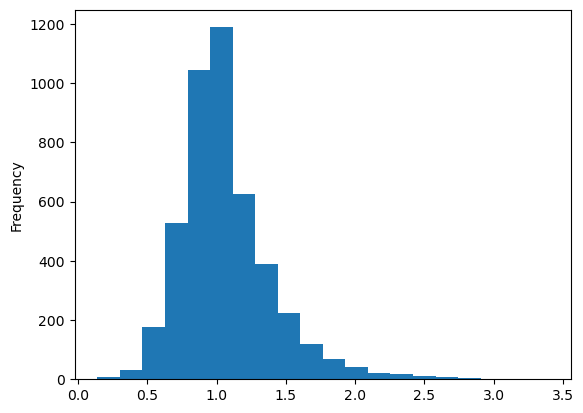

In [793]:
pomer.plot.hist(bins=20)

In [794]:
neutralita = pd.DataFrame(pomer).rename(columns={0:'cetnost'})
neutralita['odchylka'] = neutralita['cetnost'].apply(lambda x: x-1 if x>1 else 1-x)
neutralita.sort_values(by='odchylka').head(60)

,cetnost,odchylka
slova,,
ale,1.000000,0.000000
když,1.000000,0.000000
být,1.000000,0.000000
jako,1.000000,0.000000
jediný,0.999908,0.000092
zvolit,0.999842,0.000158
plavat,0.999842,0.000158
speciální,0.999842,0.000158
osobnost,0.999842,0.000158


## Slova více používaná muži-spisovateli

In [796]:
pomer.sort_values(ascending=False).head(25)

slova
pistole       3.395210
prezident     3.258795
velet         2.858212
ruský         2.849551
kulka         2.748503
západní       2.728293
poctivý       2.710461
válečný       2.688753
politik       2.667665
vůl           2.652507
kapitán       2.649701
zvláště       2.639133
motor         2.559880
kladivo       2.500936
střílet       2.480267
státní        2.464265
Evropa        2.453349
vesta         2.425150
riziko        2.425150
komín         2.425150
jednotka      2.425150
Vídeň         2.425150
zápas         2.376647
technický     2.372429
civilizace    2.370033
dtype: float64

In [797]:
pomer[pomer.index.str.endswith('la')].sort_values()

slova
netušila     0.206689
neuměla      0.242515
lekla        0.248733
nečekala     0.259837
užívala      0.259837
zahlédla     0.273256
nestihla     0.303144
ucítila      0.307668
ptala        0.348441
četla        0.378930
chystala     0.382918
chytla       0.385819
vyhrkla      0.404192
přejela      0.426647
zadívala     0.433062
nechávala    0.454716
usmívala     0.454716
nešla        0.468495
neřekla      0.482422
sklopila     0.485030
nalila       0.491584
vzdychla     0.499296
strčila      0.528558
odvětila     0.538922
ušklíbla     0.538922
odložila     0.548546
mávla        0.553567
zasmála      0.554320
zažila       0.588965
vyrazila     0.597238
odsekla      0.606287
nepřišla     0.606287
jezdila      0.650650
přikývla     0.672029
stodola      0.752633
dokola       0.771639
pohladila    0.784607
Hela         0.826268
škola        0.879117
jehla        0.952737
cela         0.981083
docela       0.982131
kapitola     0.996044
kapela       1.015941
síla         1.017508
zcel

## Slova více používaná ženami-spisovatelkami

Pleso vypadá spíš jako špatné lemma slova ples.

In [800]:
(1 / pomer).sort_values(ascending=False).head(25)

slova
babi           7.257284
netušila       4.838189
neuměla        4.123457
lekla          4.020370
nečekala       3.848560
užívala        3.848560
zahlédla       3.659568
nestihla       3.298765
ucítila        3.250254
pyžamo         3.223793
povytáhnout    3.051358
příšerně       3.023868
ptala          2.869926
rande          2.803951
mamka          2.791263
koláč          2.791263
salát          2.773962
miminko        2.773962
kamarádka      2.736476
čokoláda       2.657339
četla          2.639012
chystala       2.611523
chytla         2.591887
sexy           2.537512
navrch         2.537512
dtype: float64

## Graf

In [802]:
pomer_vsech.sample(20)

slova
kašlat           1.165937
neroztřást            NaN
gretou                NaN
bunkrech              NaN
dárfúr                NaN
nerozporovala         NaN
vsechno               NaN
zazmatkovat      0.606287
nachystané       0.606287
ošklivý          0.777878
využívaný             NaN
proschnul             NaN
pionýry               NaN
podvyživené           NaN
páteřní          1.212575
mannerheima           NaN
šlaufová              NaN
nakrmili         1.212575
otíka                 NaN
očarovávaly           NaN
dtype: float64

In [803]:
pomer.reset_index()

,slova,0
0,Adam,1.254388
1,Amerika,1.301300
2,Anglie,1.162051
3,Anna,1.151946
4,Brno,1.010479
...,...,...
4506,žádost,1.477826
4507,žák,1.414671
4508,žíla,1.387725
4509,žít,0.913368


In [965]:
import polars as pl

In [1003]:
problematicke = ['pleso','Karlov','podpatku']
pomer2 = pomer.reset_index().rename(columns={'slova':'slovo',0:'rozdíl'})
pomer2 = pomer2[~pomer2['slovo'].isin(problematicke)]
pomer2 = pomer2.groupby('slovo')['rozdíl'].first()
do_grafu = pd.concat([
    (1 / pomer).sort_values(ascending=False).head(10),
    -pomer.sort_values(ascending=False).head(10)
]).sort_values(ascending=False).reset_index().rename(columns={'slova':'slovo',0:'rozdíl'})
do_grafu['mz'] = do_grafu['rozdíl'].apply(lambda x: 'mužští autoři' if x < 0 else 'ženské autorky')
do_grafu

,slovo,rozdíl,mz
0,babi,7.257284,ženské autorky
1,netušila,4.838189,ženské autorky
2,neuměla,4.123457,ženské autorky
3,lekla,4.020370,ženské autorky
4,nečekala,3.848560,ženské autorky
5,užívala,3.848560,ženské autorky
6,zahlédla,3.659568,ženské autorky
7,nestihla,3.298765,ženské autorky
8,ucítila,3.250254,ženské autorky
9,pyžamo,3.223793,ženské autorky


In [1007]:
do_grafu2 = do_grafu
do_grafu2['rozdíl'] = do_grafu2['rozdíl'].apply(lambda x: abs(x))
do_grafu2

,slovo,rozdíl,mz
0,babi,7.257284,ženské autorky
1,netušila,4.838189,ženské autorky
2,neuměla,4.123457,ženské autorky
3,lekla,4.020370,ženské autorky
4,nečekala,3.848560,ženské autorky
5,užívala,3.848560,ženské autorky
6,zahlédla,3.659568,ženské autorky
7,nestihla,3.298765,ženské autorky
8,ucítila,3.250254,ženské autorky
9,pyžamo,3.223793,ženské autorky


In [805]:
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [806]:
def irozhlas_conf():

    return {
        "config" : {
             "title": {'font': "Noticia Text",
                      'fontSize': 14,
                      'anchor': 'start',
                       'fontWeight': 'bolder',
                    'subtitleFont': 'Noticia Text',
                      'subtitleFontSize': 12,
                       'subtitleFontWeight': 'lighter',
                      'subtitlePadding': 12,
                       'dy': -12,
                      },
             "axis": {
                "labelFont": "Asap",
                "titleFont": "Asap",
                 "fontWeight": "lighter",
                "titleFontWeight": "lighter",
                "labelFontSize": 10,
                "titleFontSize": 10,
                'labelPadding': 2,
                 'titlePadding': 10
            },
            "legend": {
                "labelFont": "Asap",
                "labelFontWeight": "normal",
                "titleFont": "Asap",
                "titleFontWeight": "normal",
                "labelFontSize": 10,
                "titleFontSize": 10
            }
        }
    }

alt.themes.register('irozhlas', irozhlas_conf)
alt.themes.enable('irozhlas')

ThemeRegistry.enable('irozhlas')

In [1081]:
titulek = ["Slova používaná častěji spisovatelkami a spisovateli"]
kredit = "zdroj dat: Česká národní bibliografie · vizualizace: iROZHLAS.cz · 2025"
podtitulek = f"Analýza vychází z {graf_rozsah} tisíc stran ukázek z próz {graf_zeny} českých autorek a {graf_muzi} autorů vydaných mezi lety {graf_rok_min} a {graf_rok_max}. Graf srovnává pouze častá slova, která se objevila alespoň v {hranice} knihách, vypadlo tak například ryze mužské slovo „erekce“. Do výsledku se nepromítá, zda se v dané ukázce slovo objevilo jednou, nebo víckrát."
podtitulek = wrap(podtitulek, 70)

In [808]:
from textwrap import wrap


In [1001]:
max_abs_value = max(abs(do_grafu['rozdíl'].max()), abs(do_grafu['rozdíl'].min()))

mz_graf = alt.Chart(do_grafu, title={'text': titulek, 'subtitle': podtitulek}, width=300).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6'), scale=alt.Scale(domain=[-max_abs_value, max_abs_value])),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("rozdíl:Q", legend=None, scale=alt.Scale(range=['#84c0e4','#E7666E']))

)

mz_graf

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [1049]:
mz_graf = alt.Chart(do_grafu, title={'text': titulek, 'subtitle': podtitulek}, width=300).mark_bar().encode(
  alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
  alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
  alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#84c0e4','#E7666E'])),
).transform_filter(alt.datum['mz:N'] == 'right_facet_value').facet('mz:N')
mz_graf

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.FacetChart(...)

In [1051]:
mz_graf = alt.Chart(do_grafu, title={'text': titulek, 'subtitle': podtitulek}, width=300).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#84c0e4','#E7666E'])),
    alt.Row('mz:N', title=None,
            header=alt.Header(labelAngle=0, labelAlign='left',
                              labelAnchor='middle', labelFont='Asap'))
).transform_filter(
    alt.datum.mz == alt.datum.mz
)

mz_graf

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [1057]:
str(do_grafu.sample(5))

'       slovo    rozdíl              mz\n15     kulka  2.748503   mužští autoři\n9     pyžamo  3.223793  ženské autorky\n17     velet  2.858212   mužští autoři\n12   válečný  2.688753   mužští autoři\n4   nečekala  3.848560  ženské autorky'

In [1061]:
mz_graf = alt.Chart(
    do_grafu,
    title={'text': titulek, 'subtitle': podtitulek},
    width=300
).mark_bar().encode(
    alt.X(
        "rozdíl:Q", 
        title=None, 
        axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')
    ),
    alt.Y(
        'slovo:N', 
        sort='-x', 
        title=None, 
        axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)
    ),
    alt.Color(
        "mz:N", 
        legend=None, 
        scale=alt.Scale(range=['#84c0e4', '#E7666E'])
    ),
    alt.Row(
        'mz:N',
        title=None,
        header=alt.Header(
            labelAngle=0, 
            labelAlign='left',
            labelAnchor='middle', 
            labelFont='Asap'
        )
    )
).transform_filter(
    alt.datum.mz != ''  # This ensures we filter rows based on non-empty 'mz'.
)

mz_graf

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [1083]:
muzsti_autori = alt.Chart(
    do_grafu[do_grafu["mz"] == "mužští autoři"],  # Filter the data for this group
    title='Mužští Autoři'
).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#84c0e4'])),
)

# Chart for "ženské autorky"
zenske_autorky = alt.Chart(
    do_grafu[do_grafu["mz"] == "ženské autorky"],  # Filter the data for this group
    title='Ženské Autorky'
).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#E7666E'])),
)

# Combine the charts
mz_graf = alt.vconcat(
    muzsti_autori,
    zenske_autorky
).resolve_scale(
    color='independent'  # Allows each chart to use its own color encoding
)

mz_graf

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.

alt.VConcatChart(...)

In [1101]:
# Chart for "mužští autoři"
muzsti_autori = alt.Chart(
    do_grafu[do_grafu["mz"] == "mužští autoři"]
).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#84c0e4'])),
).properties(title="mužští autoři", width=120)

# Chart for "ženské autorky"
zenske_autorky = alt.Chart(
    do_grafu[do_grafu["mz"] == "ženské autorky"]
).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#E7666E'])),
).properties(title="ženské autorky", width=120)

# Combine the charts with shared x-axis scale and original title
mz_graf = alt.hconcat(
    zenske_autorky,
    muzsti_autori
).resolve_scale(
    x='shared',  # Ensures the x-axes share the same scale
    color='independent'  # Allows each chart to use its own color encoding
).properties(
    title={
        'text': titulek,
        'subtitle': podtitulek
    }
)

mz_graf

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.

alt.HConcatChart(...)

In [1067]:
mz_graf = alt.Chart(do_grafu).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#84c0e4', '#E7666E'])),
).facet(
    'mz:N'
).resolve_scale(
    color='independent'
)

mz_graf


C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.FacetChart(...)

In [1055]:
mz_graf = alt.Chart(do_grafu, title={'text': titulek, 'subtitle': podtitulek}, width=300).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#84c0e4','#E7666E'])),
    alt.Row('mz:N', title=None,
            header=alt.Header(labelAngle=0, labelAlign='left',
                              labelAnchor='middle', labelFont='Asap'))
)

mz_graf

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [1059]:
mz_graf = alt.Chart(do_grafu, title={'text': titulek, 'subtitle': podtitulek}, width=300).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#84c0e4','#E7666E'])),
    alt.Row('mz:N', title=None,
            header=alt.Header(labelAngle=0, labelAlign='left', labelAnchor='middle', labelFont='Asap'))
)

mz_graf


C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [1041]:
# Create chart for positive differences
positive = alt.Chart(do_grafu, title={'text': titulek, 'subtitle': podtitulek}, width=300).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, 
          axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6'), 
          scale=alt.Scale(domain=[-max_abs_value, max_abs_value])),
    alt.Y('slovo:N', sort='-x', title=None, 
          axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("rozdíl:Q", legend=None, 
              scale=alt.Scale(range=['#84c0e4','#E7666E']))
).transform_filter(
    'datum.rozdíl >= 0'
)

# Create chart for negative differences
negative = alt.Chart(do_grafu, width=300).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, 
          axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6'), 
          scale=alt.Scale(domain=[-max_abs_value, max_abs_value])),
    alt.Y('slovo:N', sort='-x', title=None, 
          axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("rozdíl:Q", legend=None, 
              scale=alt.Scale(range=['#84c0e4','#E7666E']))
).transform_filter(
    'datum.rozdíl < 0'
)

# Combine the charts with faceting
mz_graf = (positive + negative).facet(
    row=alt.Row('sign:N', title=None,
                header=alt.Header(labelAngle=0, labelAlign='left', 
                                labelAnchor='middle', labelFont='Asap'))
).transform_calculate(
    sign="datum.rozdíl >= 0 ? 'Positive' : 'Negative'"
)

mz_graf

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.FacetChart(...)

In [1039]:
base = alt.Chart(do_grafu).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#84c0e4','#E7666E']))
)

mz_graf = base.facet(
    row='mz:N',
    title={'text': titulek, 'subtitle': podtitulek},
).properties(
    width=300
).transform_filter(
    alt.datum.mz == alt.datum['mz:N']
)

mz_graf

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


SchemaValidationError: `FacetChart` has no parameter named 'width'

Existing parameter names are:
data    autosize     columns       name      spacing     
facet   background   config        padding   title       
spec    bounds       datasets      params    transform   
align   center       description   resolve   usermeta    

See the help for `FacetChart` to read the full description of these parameters

alt.FacetChart(...)

In [1033]:
base = alt.Chart(do_grafu).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6')),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("mz:N", legend=None, scale=alt.Scale(range=['#84c0e4','#E7666E']))
)

mz_graf = base.facet(
    row='mz:N',
    title={'text': titulek, 'subtitle': podtitulek},
).properties(
    width=300
).transform_filter(
    alt.datum.mz == alt.datum['mz:N']
)

mz_graf


C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


SchemaValidationError: `FacetChart` has no parameter named 'width'

Existing parameter names are:
data    autosize     columns       name      spacing     
facet   background   config        padding   title       
spec    bounds       datasets      params    transform   
align   center       description   resolve   usermeta    

See the help for `FacetChart` to read the full description of these parameters

alt.FacetChart(...)

In [1095]:
# Create separate charts for each mz value and combine them
muzsti = alt.Chart(do_grafu.query("mz == 'mužští autoři'"), 
                  title={'text': titulek, 'subtitle': podtitulek}, 
                  width=300).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, 
          axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6'), 
          scale=alt.Scale(domain=[-max_abs_value, max_abs_value])),
    alt.Y('slovo:N', sort='-x', title=None, 
          axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("rozdíl:Q", legend=None, 
              scale=alt.Scale(range=['#84c0e4','#E7666E'])),
    row=alt.Row("mz:N", title=None, spacing=15,
                header=alt.Header(labelAngle=0, labelAlign='left', 
                                labelAnchor='middle', labelFont='Asap'))
)

zenske = alt.Chart(do_grafu.query("mz == 'ženské autorky'"), 
                  width=300).mark_bar().encode(
    alt.X("rozdíl:Q", title=None, 
          axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6'), 
          scale=alt.Scale(domain=[-max_abs_value, max_abs_value])),
    alt.Y('slovo:N', sort='-x', title=None, 
          axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("rozdíl:Q", legend=None, 
              scale=alt.Scale(range=['#84c0e4','#E7666E'])),
    row=alt.Row("mz:N", title=None, spacing=15,
                header=alt.Header(labelAngle=0, labelAlign='left', 
                                labelAnchor='middle', labelFont='Asap'))
)

mz_graf = muzsti + zenske
mz_graf

ValueError: Faceted charts cannot be layered. Instead, layer the charts before faceting.

In [907]:
def me_to_neurazi(zaklad_grafu, soubor, kredity):

    os.makedirs("grafy", exist_ok=True)
    
    credits = pl.DataFrame({'text': [kredity]})
    credits = alt.Chart(credits.to_pandas(), width=300).encode(text=alt.Text('text:N')).mark_text(fontSize=10,font="Asap", baseline='line-bottom')
    combined_chart = alt.vconcat(zaklad_grafu, credits)

    combined_chart.save(os.path.join("grafy",f"{soubor}.svg"))
    combined_chart.save(os.path.join("grafy",f"{soubor}.png"), ppi=400)
    
    return combined_chart

In [1087]:
me_to_neurazi(mz_graf, "muzska_zenska_slova", "data: Česká nár. bibliografie, martinus.cz · vizualizace: iROZHLAS.cz · 2025")

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.

alt.VConcatChart(...)

In [810]:
# Calculate max absolute value for domain scaling
max_abs_value = max(abs(do_grafu['rozdíl'].max()), abs(do_grafu['rozdíl'].min()))

# Base chart with bars
base = alt.Chart(do_grafu, title={'text': titulek, 'subtitle': podtitulek}, width=300)

# Bar layer
bars = base.mark_bar().encode(
    alt.X("rozdíl:Q", 
          title=None, 
          axis=alt.Axis(
              labelExpr="datum.label + '×'", 
              domainOpacity=0, 
              tickColor='#DCDDD6',
              labels=False  # This removes the x-axis labels
          ),
          scale=alt.Scale(domain=[-max_abs_value, max_abs_value])
    ),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("rozdíl:Q", legend=None, scale=alt.Scale(range=['#84c0e4','#E7666E']))
)

# Text layer
text = base.mark_text(
    align='left',           # Align text to the left of the position
    dx=5,                   # Offset text slightly to the right of the bar end
    baseline='middle'       # Center text vertically
).encode(
    alt.X("rozdíl:Q"),
    alt.Y('slovo:N', sort='-x'),
    text=alt.Text('rozdíl:Q', format='.1f')  # Format numbers to 1 decimal place
)

# Combine the layers and configure
(bars + text).configure_axis(
    grid=False
)

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [811]:
max_abs_value = max(abs(do_grafu['rozdíl'].max()), abs(do_grafu['rozdíl'].min()))

# Base chart
base = alt.Chart(do_grafu, title={'text': titulek, 'subtitle': podtitulek}, width=300)

# Bar chart
bars = base.mark_bar().encode(
    alt.X("rozdíl:Q", 
          title=None, 
          axis=alt.Axis(labelExpr="datum.label + '×'", domainOpacity=0, tickColor='#DCDDD6'),
          scale=alt.Scale(domain=[-max_abs_value, max_abs_value])
    ),
    alt.Y('slovo:N', sort='-x', title=None, axis=alt.Axis(tickColor='#DCDDD6', domainOpacity=0)),
    alt.Color("rozdíl:Q", legend=None, scale=alt.Scale(range=['#84c0e4','#E7666E']))
)

# Create annotations layer
annotations = alt.Chart(pd.DataFrame({
    'x': [-max_abs_value/2, max_abs_value/2],
    'y': [do_grafu['slovo'].iloc[-1], do_grafu['slovo'].iloc[0]],  # Bottom and top positions
    'text': ['více maskulinní', 'více femininní']
})).mark_text(
    fontSize=11,
    fontStyle='italic',
    opacity=0.6
).encode(
    x='x:Q',
    y='y:N',
    text='text:N'
)

# Combine the layers and configure
(bars + annotations).configure_axis(
    grid=False
)

C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\Users\micha\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)